In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns  # Ensure seaborn is imported

In [10]:
# Load the data
data = pd.read_excel('/Users/rajeevmaharaj/Desktop/BANYIT/PYTHON_LOS.xlsm')



/Users/rajeevmaharaj/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Web Extension extension is not supported and will be removed
  for idx, row in parser.parse():


In [11]:
pwd


'/Users/rajeevmaharaj/Desktop'

In [12]:
# Define the target variable and predictors
target = 'LOSdays'
predictors = data.columns.drop(target)



In [13]:
#Normal regresssion

# Standardize the predictor variables
data_standardized = (data[predictors] - data[predictors].mean()) / data[predictors].std()
data_standardized[target] = data[target]  # Keep the target variable unchanged



In [5]:
# Initialize the list of included predictors
included = []

while True:
    changed = False
    
    # Forward step
    excluded = list(set(predictors) - set(included))
    new_pval = pd.Series(index=excluded, dtype=float)
    for new_column in excluded:
        model = sm.OLS(data_standardized[target], sm.add_constant(data_standardized[included + [new_column]])).fit()
        new_pval[new_column] = model.pvalues[new_column]
    best_pval = new_pval.min()
    if best_pval < 0.05:  # Threshold for adding variables
        best_feature = new_pval.idxmin()
        included.append(best_feature)
        changed = True

    # Backward step
    model = sm.OLS(data_standardized[target], sm.add_constant(data_standardized[included])).fit()
    pvalues = model.pvalues.iloc[1:]
    worst_pval = pvalues.max()
    if worst_pval > 0.05:  # Threshold for removing variables
        worst_feature = pvalues.idxmax()
        included.remove(worst_feature)
        changed = True

    if not changed:
        break



In [6]:

# Define the target variable and predictors
target = 'LOSdays'
predictors = ['Gender', 'age', 'Adult ', 'Teen', 'Middle Age ', 'Child ', 'Senior', 
              'EMERGENCY', 'NEWBORN', 'URGENT', 'ELECTIVE', 'admission', 'Private ', 
              'Medicare', 'Medicaid', 'Government', 'Self Pay ', 'NumCallouts', 
              'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 
              'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 
              'NumTransfers', 'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum']

# Standardize the predictor variables
data_standardized = (data[predictors] - data[predictors].mean()) / data[predictors].std()
data_standardized[target] = data[target]  # Keep the target variable unchanged

# Fit the model using all specified predictors
model = sm.OLS(data_standardized[target], sm.add_constant(data_standardized[predictors])).fit()

# Display the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                LOSdays   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     1911.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:59:25   Log-Likelihood:            -2.1389e+05
No. Observations:               58976   AIC:                         4.278e+05
Df Residuals:                   58948   BIC:                         4.281e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.1167      0.038  

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the standardized data for VIF calculation
X = sm.add_constant(data_standardized[predictors])

# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print(vif_data)


            Variable           VIF
0              const  5.597676e+01
1             Gender  1.012969e+00
2                age  8.215558e+06
3             Adult   5.292332e+06
4               Teen  1.156375e+07
5        Middle Age   3.361260e+05
6             Child   4.922303e+05
7             Senior  3.284058e+05
8          EMERGENCY  3.581148e+06
9            NEWBORN  8.652295e+06
10            URGENT  6.865840e+07
11          ELECTIVE  9.145071e+05
12         admission  2.367117e+06
13          Private   1.668303e+05
14          Medicare  1.433292e+06
15          Medicaid  1.613038e+07
16        Government  8.521864e+07
17         Self Pay   7.177074e+07
18       NumCallouts  6.828993e+05
19      NumDiagnosis  5.264895e+07
20          NumProcs  3.811260e+07
21      NumCPTevents  4.940163e+07
22          NumInput  9.216637e+06
23           NumLabs  9.481851e+07
24      NumMicroLabs  3.348523e+07
25          NumNotes  2.881617e+08
26         NumOutput  1.143749e+07
27             NumRx

In [11]:
import pandas as pd
import statsmodels.api as sm

def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    
    Arguments:
    X - pandas.DataFrame with candidate features
    y - list-like with the target
    initial_list - list of features to start with (column names of X)
    threshold_in - include a feature if its p-value < threshold_in
    threshold_out - exclude a feature if its p-value > threshold_out
    verbose - whether to print the sequence of inclusions and exclusions
    
    Returns: list of selected features 
    """
    
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Example usage:
# Assuming 'data_standardized' is your DataFrame of independent variables and 'LOSdays' is your dependent variable.
result = stepwise_selection(data_standardized, data['LOSdays'])

print('resulting features:')
print(result)


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  LOSgroupNum                    with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NEWBORN                        with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  LOSdays                        with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Middle Age                     with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Self Pay                       with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Gender                         with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumRx                          with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 0.0
Drop Senior                         with p-value 0.413468


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcEvents                  with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 0.0
Drop Teen                           with p-value 0.370143


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 0.0
Drop Middle Age                     with p-value 0.863787


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Private                        with p-value 0.0
Drop Self Pay                       with p-value 0.0555301


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  URGENT                         with p-value 0.0
Drop Adult                          with p-value 0.94995


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Self Pay                       with p-value 0.0
Drop Gender                         with p-value 0.715166


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Middle Age                     with p-value 0.0
Drop EMERGENCY                      with p-value 0.837734


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumCPTevents                   with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicare                       with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumChartEvents                 with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 0.0
Drop NumTransfers                   with p-value 0.741029


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 0.0
Drop Government                     with p-value 0.110202


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Gender                         with p-value 0.0
Drop NumTransfers                   with p-value 0.283522


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Child                          with p-value 0.0
Drop Self Pay                       with p-value 0.812934


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 0.0
Drop Teen                           with p-value 0.624717


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumDiagnosis                   with p-value 0.0
Drop Medicare                       with p-value 0.374736


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 0.0
Drop Private                        with p-value 0.256271


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumCallouts                    with p-value 0.0
Drop TotalNumInteract               with p-value 0.341052


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumOutput                      with p-value 0.0
Drop Medicaid                       with p-value 0.497293


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicare                       with p-value 1.57164e-70
Drop NumCPTevents                   with p-value 0.180293


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Self Pay                       with p-value 0.0
Drop Senior                         with p-value 0.82038


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 0.0
Drop Adult                          with p-value 0.924838


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumCPTevents                   with p-value 0.0
Drop ExpiredHospital                with p-value 0.325517


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumMicroLabs                   with p-value 0.0
Drop NumInput                       with p-value 0.878412


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 0.0
Drop NumDiagnosis                   with p-value 0.405309


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 4.10228e-98
Drop Government                     with p-value 0.539729


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 0.0
Drop NumProcEvents                  with p-value 0.708112


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  admission                      with p-value 0.0
Drop NumNotes                       with p-value 0.148306


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcEvents                  with p-value 5.61841e-126
Drop Adult                          with p-value 0.536169


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 0.0
Drop ELECTIVE                       with p-value 0.105726


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 1.27395e-294
Drop admission                      with p-value 0.243013


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 5.73221e-238
Drop NumOutput                      with p-value 0.880872


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 5.26019e-269


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 1.11762e-42
Drop Senior                         with p-value 0.784899


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Private                        with p-value 1.12489e-256
Drop Self Pay                       with p-value 0.365245


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 1.54586e-41
Drop NumChartEvents                 with p-value 0.792662


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Self Pay                       with p-value 1.99762e-117
Drop Teen                           with p-value 0.962969


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 5.12438e-244


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 0.0
Drop Adult                          with p-value 0.354959


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumOutput                      with p-value 1.28816e-301
Drop NumCPTevents                   with p-value 0.62088


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 7.33445e-99
Drop URGENT                         with p-value 0.600117


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumChartEvents                 with p-value 4.4038e-161
Drop NEWBORN                        with p-value 0.505241


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumCPTevents                   with p-value 1.09431e-33
Drop NumProcs                       with p-value 0.830976


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 4.10046e-29
Drop EMERGENCY                      with p-value 0.778838


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 1.67793e-103
Drop ELECTIVE                       with p-value 0.122799


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 1.1186e-109
Drop NumNotes                       with p-value 0.534521


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  URGENT                         with p-value 1.03319e-31
Drop ExpiredHospital                with p-value 0.072051


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 0.0
Drop Senior                         with p-value 0.374155


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 1.05062e-149


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  age                            with p-value 0.0
Drop Gender                         with p-value 0.387102


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 0.0
Drop NumNotes                       with p-value 0.490594


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumDiagnosis                   with p-value 6.60037e-149
Drop NumTransfers                   with p-value 0.936217


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 0.0
Drop Government                     with p-value 0.964809


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  admission                      with p-value 8.00146e-166
Drop NumProcEvents                  with p-value 0.48393


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Gender                         with p-value 1.23004e-215
Drop NumNotes                       with p-value 0.0578635


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 1.49421e-132
Drop ELECTIVE                       with p-value 0.543098


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcEvents                  with p-value 0.0
Drop NumOutput                      with p-value 0.685979


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 1.32123e-47


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NEWBORN                        with p-value 4.84698e-53
Drop Child                          with p-value 0.398051


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumOutput                      with p-value 5.59455e-185
Drop Teen                           with p-value 0.960927


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 2.15298e-79
Drop URGENT                         with p-value 0.485809


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  URGENT                         with p-value 8.33151e-289
Drop NumTransfers                   with p-value 0.191047


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 1.17513e-137
Drop Middle Age                     with p-value 0.783525


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Child                          with p-value 5.65553e-157
Drop NumProcs                       with p-value 0.833819


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 4.93785e-105
Drop NumLabs                        with p-value 0.94384


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 7.75e-44
Drop TotalNumInteract               with p-value 0.551345


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 2.9943e-244
Drop NumOutput                      with p-value 0.556193


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 5.47609e-205
Drop Adult                          with p-value 0.164288


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 1.15452e-204
Drop ExpiredHospital                with p-value 0.790782


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 9.30473e-43
Drop NumLabs                        with p-value 0.156489


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 3.85197e-254
Drop Senior                         with p-value 0.159391


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 9.43278e-227
Drop NumNotes                       with p-value 0.819549


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumOutput                      with p-value 9.04846e-188
Drop NumMicroLabs                   with p-value 0.438453


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Middle Age                     with p-value 7.9411e-93
Drop NEWBORN                        with p-value 0.37356


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 2.85757e-167


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 8.15079e-106
Drop URGENT                         with p-value 0.793385


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumMicroLabs                   with p-value 1.22137e-16
Drop NumTransfers                   with p-value 0.117393


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 7.54701e-52
Drop EMERGENCY                      with p-value 0.44019


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 1.03142e-06
Drop admission                      with p-value 0.279617


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 2.82719e-25
Drop Government                     with p-value 0.154948


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  URGENT                         with p-value 3.44841e-81
Drop Adult                          with p-value 0.123171


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NEWBORN                        with p-value 3.29967e-69
Drop Medicaid                       with p-value 0.136293


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  admission                      with p-value 0.0
Drop NumProcs                       with p-value 0.794111


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 1.77773e-27
Drop TotalNumInteract               with p-value 0.737804


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 3.95874e-122
Drop Middle Age                     with p-value 0.368918


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 5.40718e-09
Drop NumLabs                        with p-value 0.610214


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Middle Age                     with p-value 1.09429e-60
Drop NumMicroLabs                   with p-value 0.663


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 6.71524e-241
Drop Teen                           with p-value 0.486894


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 4.44022e-59
Drop Adult                          with p-value 0.683354


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumMicroLabs                   with p-value 1.24861e-28
Drop Senior                         with p-value 1.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 0.0
Drop Private                        with p-value 0.960225


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 6.05468e-171
Drop ELECTIVE                       with p-value 0.698737


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Private                        with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 6.29536e-90
Drop admission                      with p-value 0.932179


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 4.85199e-20
Drop NumOutput                      with p-value 0.401594


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  admission                      with p-value 0.0
Drop NumInput                       with p-value 0.799618


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumOutput                      with p-value 1.75914e-21
Drop Government                     with p-value 0.785752


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 4.64322e-145
Drop Teen                           with p-value 0.609374


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 7.92777e-16
Drop Medicaid                       with p-value 0.842008


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 2.11468e-135
Drop Medicare                       with p-value 0.890131


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Teen                           with p-value 2.38437e-103
Drop ExpiredHospital                with p-value 0.686635


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 0.0
Drop EMERGENCY                      with p-value 0.725697


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicare                       with p-value 1.68815e-179


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 3.57845e-14
Drop Self Pay                       with p-value 0.691137


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 1.50655e-12
Drop NumNotes                       with p-value 0.194201


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Self Pay                       with p-value 7.03082e-09
Drop Child                          with p-value 0.77809


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 1.18407e-20
Drop NumLabs                        with p-value 0.282599


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 1.08396e-15
Drop age                            with p-value 0.846439


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Child                          with p-value 8.07026e-27
Drop EMERGENCY                      with p-value 0.893404


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 1.0938e-92
Drop NumDiagnosis                   with p-value 0.890459


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumDiagnosis                   with p-value 2.49624e-11
Drop ELECTIVE                       with p-value 0.735318


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  age                            with p-value 0.0
Drop Child                          with p-value 0.960628


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 1.93327e-236
Drop NumMicroLabs                   with p-value 0.653127


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop NumNotes                       with p-value 0.840722


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumMicroLabs                   with p-value 2.50944e-21
Drop NumTransfers                   with p-value 0.859996


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 4.74554e-17
Drop NumChartEvents                 with p-value 0.41753


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 1.19457e-10
Drop Private                        with p-value 0.877937


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Private                        with p-value 9.48505e-219
Drop ExpiredHospital                with p-value 0.172801


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumChartEvents                 with p-value 6.69521e-13
Drop NumLabs                        with p-value 0.385372


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 1.272e-216
Drop NumChartEvents                 with p-value 0.920913


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Child                          with p-value 3.69793e-34


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 0.00862971
Drop NumTransfers                   with p-value 0.622771


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 4.4684e-05
Drop TotalNumInteract               with p-value 0.324846


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 2.46842e-10
Drop NumLabs                        with p-value 0.522858


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 7.38515e-14
Drop Child                          with p-value 0.488682


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Child                          with p-value 1.36123e-12


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumChartEvents                 with p-value 1.86204e-76
Drop Child                          with p-value 0.766357


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Child                          with p-value 0.000201956
Drop NumRx                          with p-value 0.865757


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumRx                          with p-value 0.0
Drop NumProcEvents                  with p-value 0.48284


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcEvents                  with p-value 6.06665e-07
Drop Medicaid                       with p-value 0.332744


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 7.64374e-41
Drop NumNotes                       with p-value 0.212553


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 2.08976e-10
Drop ELECTIVE                       with p-value 0.764386


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 2.41539e-15
Drop NEWBORN                        with p-value 0.784311


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NEWBORN                        with p-value 6.61223e-50
Drop NumInput                       with p-value 0.42


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 1.60932e-172
Drop NumTransfers                   with p-value 0.707815


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 0.000533808
Drop Medicaid                       with p-value 0.323103


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 7.5544e-286
Drop NumOutput                      with p-value 0.389945


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumOutput                      with p-value 1.24382e-05
Drop Senior                         with p-value 0.526711


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Senior                         with p-value 4.21623e-79
Drop Government                     with p-value 0.769022


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Government                     with p-value 1.53487e-99
Drop Medicaid                       with p-value 1.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 1.42344e-75
Drop NumProcs                       with p-value 0.56264


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 0.00103286
Drop NumDiagnosis                   with p-value 0.820458


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumDiagnosis                   with p-value 2.55717e-63
Drop NumInput                       with p-value 0.393129


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 4.16836e-40
Drop URGENT                         with p-value 0.739373


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  URGENT                         with p-value 1.03498e-49
Drop NumInput                       with p-value 0.86434


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 2.8961e-14
Drop NumDiagnosis                   with p-value 0.199909


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop NEWBORN                        with p-value 0.783187
Add  NEWBORN                        with p-value 3.15694e-28


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop Senior                         with p-value 0.898309
Add  Senior                         with p-value 8.0594e-10


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop Adult                          with p-value 0.370622
Add  Adult                          with p-value 0.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop Senior                         with p-value 0.530123
Add  Senior                         with p-value 8.63163e-12


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop TotalNumInteract               with p-value 0.944473


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Drop Self Pay                       with p-value 0.22379


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumDiagnosis                   with p-value 1.48122e-117
Drop Private                        with p-value 0.428521


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 7.01873e-165
Drop Medicaid                       with p-value 0.808211


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Self Pay                       with p-value 1.30673e-44
Drop NumNotes                       with p-value 0.978471


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicaid                       with p-value 3.55561e-95
Drop EMERGENCY                      with p-value 1.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 6.15187e-36
Drop Middle Age                     with p-value 0.784851


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Private                        with p-value 0.0
Drop admission                      with p-value 0.840334


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 2.38312e-21
Drop NumDiagnosis                   with p-value 0.577159


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  admission                      with p-value 0.0
Drop EMERGENCY                      with p-value 1.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Middle Age                     with p-value 1.76529e-06
Drop Gender                         with p-value 0.612034


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Gender                         with p-value 3.66189e-144
Drop NumNotes                       with p-value 0.866135


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 3.38289e-26
Drop NumInput                       with p-value 0.702071


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumNotes                       with p-value 2.93163e-34
Drop NumLabs                        with p-value 0.0936447


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumDiagnosis                   with p-value 6.97279e-90
Drop NumChartEvents                 with p-value 0.11717


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumInput                       with p-value 2.80176e-07
Drop EMERGENCY                      with p-value 0.0691618


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 1.35682e-177
Drop Medicare                       with p-value 0.594874


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicare                       with p-value 1.57843e-59
Drop TotalNumInteract               with p-value 0.227244


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumChartEvents                 with p-value 1.36914e-58
Drop EMERGENCY                      with p-value 0.27455


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 2.53712e-100
Drop Gender                         with p-value 0.493587


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Gender                         with p-value 0.0
Drop NEWBORN                        with p-value 1.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NEWBORN                        with p-value 8.83777e-48
Drop EMERGENCY                      with p-value 1.0


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumLabs                        with p-value 1.71572e-31
Drop NumProcs                       with p-value 0.965927


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 1.32919e-75
Drop NumMicroLabs                   with p-value 0.336116


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumMicroLabs                   with p-value 6.20655e-106
Drop NumRx                          with p-value 0.972959


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumRx                          with p-value 1.55048e-128
Drop Gender                         with p-value 0.596516


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Gender                         with p-value 1.09325e-136
Drop URGENT                         with p-value 0.536405


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 9.15299e-103
Drop admission                      with p-value 0.951392


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  URGENT                         with p-value 2.58984e-10
Drop Middle Age                     with p-value 0.794793


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  admission                      with p-value 4.73801e-34
Drop Medicare                       with p-value 0.703445


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Middle Age                     with p-value 6.11774e-21
Drop Child                          with p-value 0.440501


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Medicare                       with p-value 5.45755e-267
Drop NumMicroLabs                   with p-value 0.545097


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  EMERGENCY                      with p-value 8.10673e-56
Drop NumTransfers                   with p-value 0.969527


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumMicroLabs                   with p-value 0.000246006
Drop TotalNumInteract               with p-value 0.9213


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 1.00743e-24
Drop Adult                          with p-value 0.340989


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 1.29985e-31
Drop ExpiredHospital                with p-value 0.606293


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Adult                          with p-value 7.01408e-64
Drop EMERGENCY                      with p-value 0.566568


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ExpiredHospital                with p-value 8.31999e-238
Drop TotalNumInteract               with p-value 0.802884


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalNumInteract               with p-value 3.71154e-98
Drop ELECTIVE                       with p-value 0.682454


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 2.96984e-100
Drop NumProcs                       with p-value 0.991528


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumProcs                       with p-value 5.56891e-14
Drop ELECTIVE                       with p-value 0.660775


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ELECTIVE                       with p-value 8.94341e-42
Drop NumTransfers                   with p-value 0.675167


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  NumTransfers                   with p-value 7.09318e-15


/var/folders/ts/47zhr5md6_551l4yy625cf780000gn/T/ipykernel_17483/2360036804.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


resulting features:
['LOSgroupNum', 'LOSdays', 'NumCallouts', 'NumCPTevents', 'Teen', 'age', 'NumProcEvents', 'NumOutput', 'Government', 'Senior', 'Self Pay ', 'Medicaid', 'Private ', 'NumNotes', 'NumDiagnosis', 'NumInput', 'NumChartEvents', 'NEWBORN', 'NumLabs', 'NumRx', 'Gender', 'URGENT', 'admission', 'Middle Age ', 'Medicare', 'NumMicroLabs', 'Adult ', 'ExpiredHospital', 'TotalNumInteract', 'NumProcs', 'ELECTIVE', 'NumTransfers']


In [12]:
#stepwise regression
# Define the target variable and predictors
target = 'LOSdays'
predictors = ['LOSgroupNum', 'NumChartEvents', 'Senior', 'Medicaid', 'NumTransfers', 'ExpiredHospital', 'NumOutput', 'NumRx', 'Medicare', 'NumCallouts', 'NumInput', 'ELECTIVE', 'NumDiagnosis', 'NumProcs', 'NEWBORN']

# Standardize the predictor variables
data_standardized = (data[predictors] - data[predictors].mean()) / data[predictors].std()
data_standardized[target] = data[target]  # Keep the target variable unchanged

# Fit the model using all specified predictors
model = sm.OLS(data_standardized[target], sm.add_constant(data_standardized[predictors])).fit()

# Display the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                LOSdays   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     3429.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:04:56   Log-Likelihood:            -2.1394e+05
No. Observations:               58976   AIC:                         4.279e+05
Df Residuals:                   58960   BIC:                         4.281e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.1150      0.037    2

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the standardized data for VIF calculation
X = sm.add_constant(data_standardized[predictors])

# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print(vif_data)


           Variable       VIF
0             const  1.000000
1       LOSgroupNum  1.263818
2    NumChartEvents  2.449768
3            Senior  1.700839
4          Medicaid  1.125658
5      NumTransfers  2.868864
6   ExpiredHospital  1.267754
7         NumOutput  2.273409
8             NumRx  1.820481
9          Medicare  1.498790
10      NumCallouts  1.257804
11         NumInput  2.285902
12         ELECTIVE  1.087096
13     NumDiagnosis  4.279273
14         NumProcs  2.115463
15          NEWBORN  1.776605


In [14]:
correlation_matrix = data.corr()

In [15]:
print(correlation_matrix)

                   LOSdays    Gender       age    Adult       Teen  \
LOSdays           1.000000 -0.006251  0.005162 -0.021461 -0.023391   
Gender           -0.006251  1.000000  0.005238 -0.005715 -0.009760   
age               0.005162  0.005238  1.000000 -0.792402 -0.198087   
Adult            -0.021461 -0.005715 -0.792402  1.000000 -0.024193   
Teen             -0.023391 -0.009760 -0.198087 -0.024193  1.000000   
Middle Age       -0.002163 -0.010879 -0.279377 -0.097721 -0.040328   
Child             0.046760  0.016170 -0.276401 -0.096680 -0.039898   
Senior           -0.017129  0.001011  0.827924 -0.335213 -0.138335   
EMERGENCY        -0.012382  0.005146  0.122143  0.095445  0.055379   
NEWBORN           0.043496  0.014875 -0.271501 -0.094966 -0.039191   
URGENT            0.026412  0.002393  0.022676 -0.001986 -0.007149   
ELECTIVE         -0.038916 -0.022964  0.099943 -0.031399 -0.031619   
admission        -0.016115 -0.016836  0.014964 -0.062346 -0.045750   
Private           0.

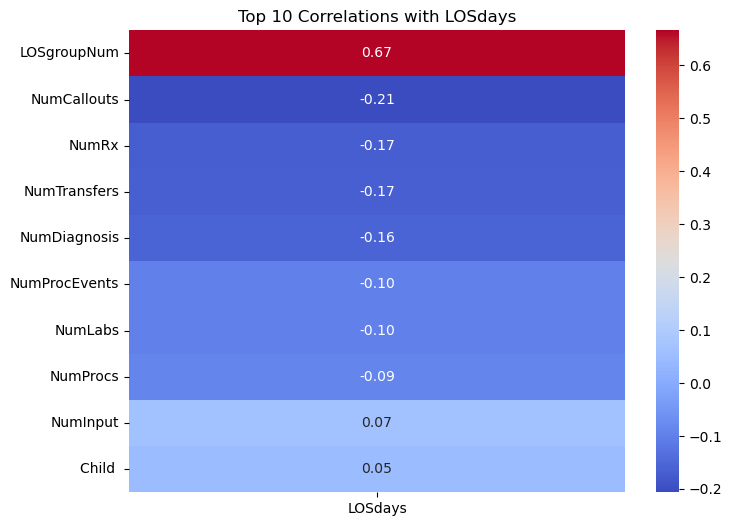

In [16]:


# Calculate the correlation matrix
correlation_matrix = data.corr()

# Isolate the 'LOSdays' correlations, sort them, and take the top 10
los_correlations = correlation_matrix['LOSdays'].drop('LOSdays').abs().sort_values(ascending=False).head(10)

# Filter the correlation matrix to include only the top 10 correlated features with 'LOSdays'
top_correlations = correlation_matrix.loc[los_correlations.index, 'LOSdays']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(top_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 10 Correlations with LOSdays')
plt.show()


In [17]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Isolate the 'LOSdays' correlations, sort them, and take the top 10
los_correlations = correlation_matrix['LOSdays'].drop('LOSdays').abs().sort_values(ascending=False).head(10)

# Convert to DataFrame for better display
top_correlations_df = los_correlations.to_frame(name='Correlation with LOSdays')

# Display the table
print(top_correlations_df)

               Correlation with LOSdays
LOSgroupNum                    0.666333
NumCallouts                    0.206370
NumRx                          0.169386
NumTransfers                   0.167765
NumDiagnosis                   0.155828
NumProcEvents                  0.099507
NumLabs                        0.097650
NumProcs                       0.087569
NumInput                       0.065388
Child                          0.046760


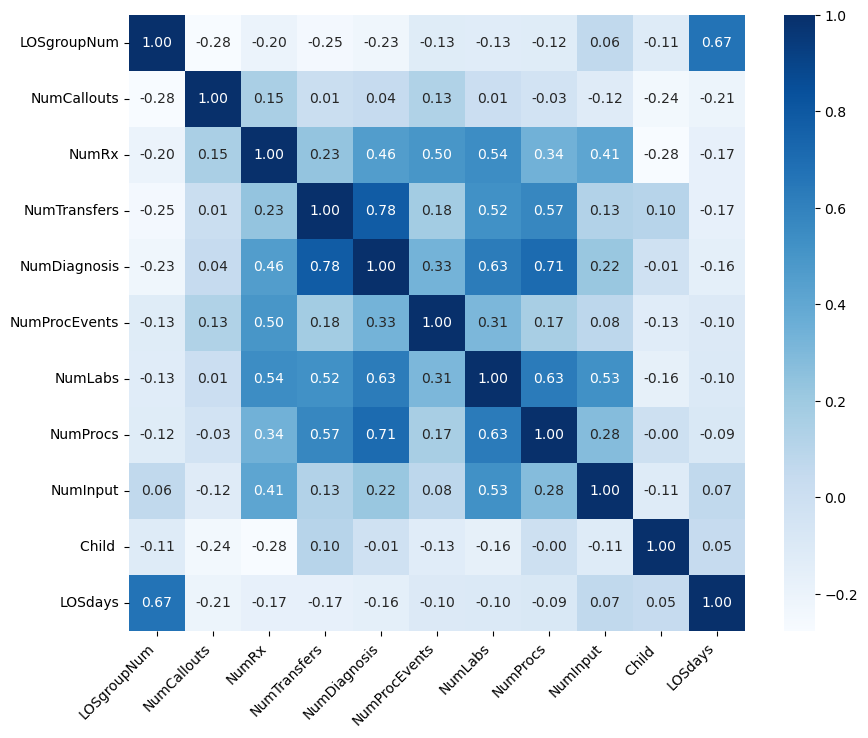

In [18]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Find the top 10 variables most correlated with 'LOSdays' (excluding 'LOSdays' itself)
top_10_vars = correlation_matrix['LOSdays'].drop('LOSdays').abs().sort_values(ascending=False).head(10).index.tolist()

# Create a smaller correlation matrix that includes only the top 10 correlated variables with 'LOSdays' and 'LOSdays' itself
reduced_matrix = data[top_10_vars + ['LOSdays']].corr()

# Plotting the reduced correlation matrix with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(reduced_matrix, annot=True, fmt=".2f", cmap='Blues', cbar=True, square=True)

# Adding labels to the matrix
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the plot
plt.show()